In [1]:
import tifffile as tf
import numpy as np
import pandas as pd

import glob
import numpy.polynomial.polynomial as P
from scipy import spatial
from scipy import interpolate
from scipy import ndimage

from sklearn import neighbors
from importlib import reload

import warnings
warnings.filterwarnings("ignore")
from matplotlib import pyplot as plt
%matplotlib inline

import arabidopsis_utils as thales
import MinimumBoundingBox as mbb

from skimage.segmentation import watershed
from skimage.feature import peak_local_max

In [2]:
reload(thales)

<module 'arabidopsis_utils' from '/home/ejam/documents/arabidopsis_scanning/jupyter/arabidopsis_utils.py'>

In [3]:
tiff_file = '../raw3d/Day7_110921_U112-3.tif'
pot_src = '../pots/'

_, fname = os.path.split(tiff_file)
bname = os.path.splitext(fname)[0]

pidx = 0

src = pot_src + bname + '/'
leaf_dst = '../leaves/'
dst = leaf_dst + bname + '/' + 'pot{}/'.format(pidx)

filename = dst + bname + '_pot{}_clean.tif'.format(pidx)
img = tf.imread(filename)

In [4]:
img, ceros, cerosshape = thales.clean_zeroes(img)

62 % reduction from input


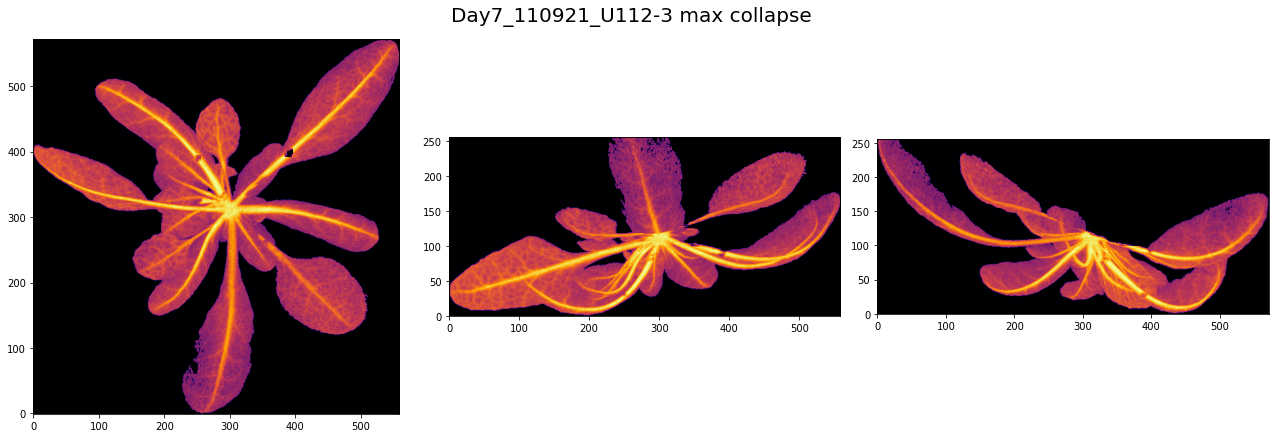

In [5]:
leafcounter = 0
snaps = thales.collapse_dimensions_max(img)
thales.plot_collapse_dimensions(snaps, bname, 'max', display=display, writefig=False, dst=dst);

In [6]:
labels,num = ndimage.label(img, structure=ndimage.generate_binary_structure(img.ndim, 1))
hist,bins = np.histogram(labels, bins=num, range=(1,num+1))
argsort_hist = np.argsort(hist)[::-1]
print(num, hist[argsort_hist][:20])

3 [636699 101768  61959]


In [7]:
cutoff = 1e-3
sz_hist = np.sum(hist)
struc=ndimage.generate_binary_structure(img.ndim, 2)
Comps = []

for j in range(num):
    i = argsort_hist[j]
    if(hist[i]/sz_hist > cutoff):
        mask = labels==i+1
        box = img.copy()
        box[~mask] = 0
        
        filename = dst + bname + '_{}_leaf{:02d}.tif'.format(pidx, leafcounter) 
        tf.imwrite(filename, box, photometric='minisblack',compress=3)
        leafcounter += 1
        
        snaps = thales.collapse_dimensions_max(box)
        Comps.append(snaps)
        
        print(j, np.around(100*hist[i]/sz_hist, 3), sep='\t')
        
print('Large components: ', len(Comps))

0	79.545
1	12.714
2	7.741
Large components:  3


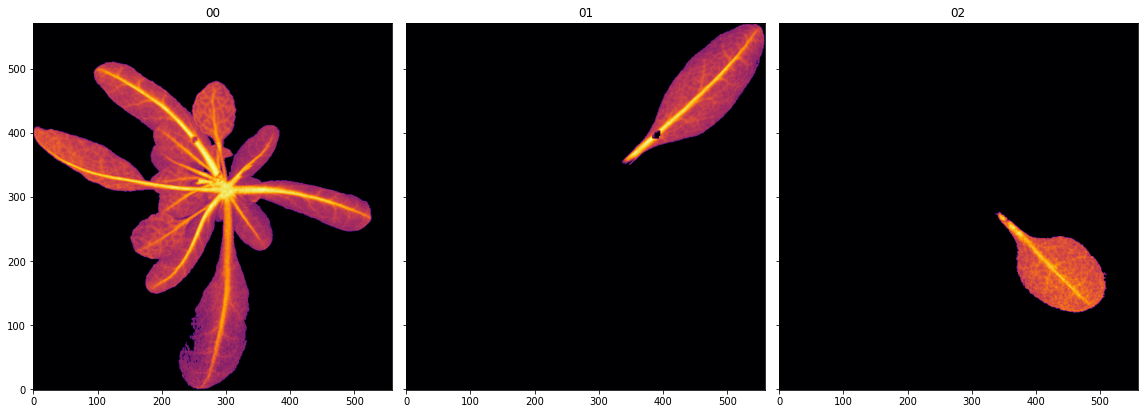

In [8]:
fig, ax = plt.subplots(1,3, figsize=(16,7), sharex=True, sharey=True)

for i,a in enumerate(ax.ravel()):
    a.imshow(Comps[i][0], origin='lower', cmap='inferno')
    a.set_title('{:02d}'.format(i))

fig.tight_layout();

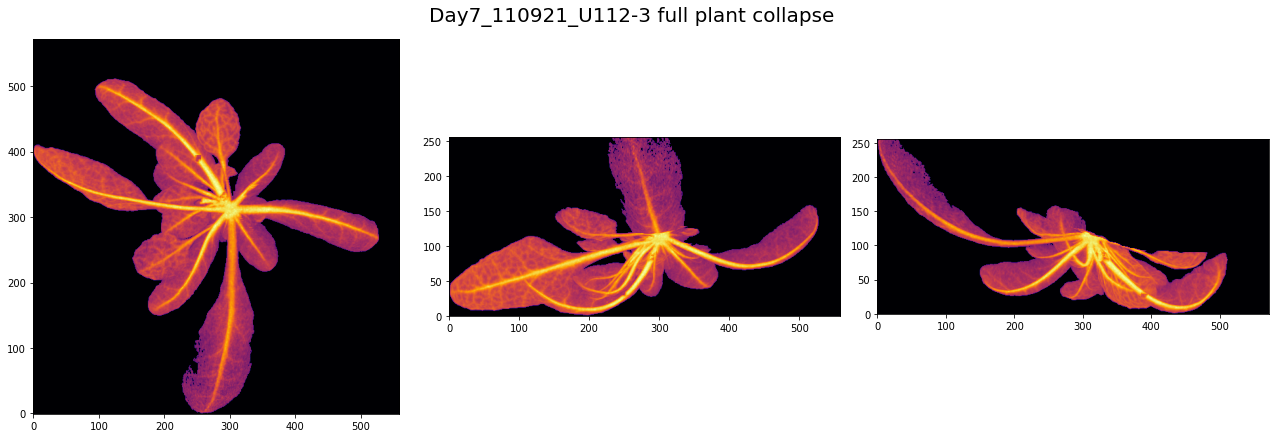

In [9]:
j = 0
i = argsort_hist[j]
if(hist[i]/sz_hist > cutoff):
    mask = labels==i+1
    box0 = img.copy()
    box0[~mask] = 0
snaps = thales.collapse_dimensions_max(box0)
thales.plot_collapse_dimensions(snaps, bname, 'full plant');

In [10]:
#petioles = img.copy()
petioles = box0.copy()
petioles[petioles < 170] = 0
#petioles = ndimage.grey_closing(petioles, size=(25,25,25))
petioles = ndimage.grey_erosion(petioles, size=(3,3,3))
#petioles = ndimage.grey_dilation(petioles, size=(5,5,5))

pcoords = np.asarray(np.nonzero(petioles))
centerby = np.mean(pcoords, axis=1) + np.asarray([0,-10,10])
cpcoords = pcoords - centerby.reshape(-1, 1)
pcenter = centerby.astype(int) 

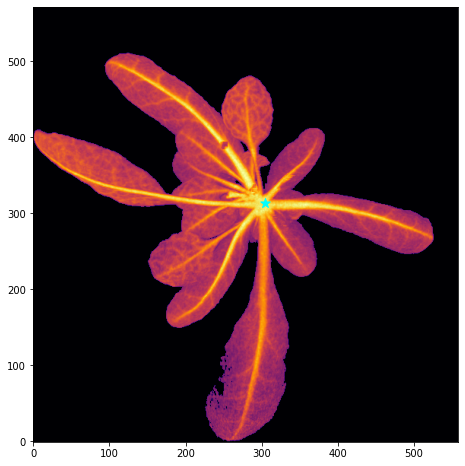

In [11]:
plt.figure(figsize=(8,8))

plt.imshow(snaps[0], cmap='inferno', origin='lower')
plt.scatter(pcenter[2], pcenter[1], s=100, c='cyan', marker='*');

In [12]:
acoords = np.asarray(np.nonzero(box0))
cpcoords = acoords - centerby.reshape(-1, 1)

In [17]:
norms = np.sqrt(np.sum(cpcoords**2, axis=0))
#norms = np.sqrt(cpcoords[1]**2 + cpcoords[2]**2)
out_mask = norms > 40
out_coords = acoords[:, out_mask]
core_coords = acoords[:, ~out_mask]

mask = np.empty_like(petioles)
mask[tuple(out_coords)] = True
plant_tips = mask*box0

mask = np.empty_like(petioles)
mask[tuple(core_coords)] = True
plant_core = mask*box0

In [18]:
tsnaps = thales.collapse_dimensions_max(plant_tips)
csnaps = thales.collapse_dimensions_max(plant_core)

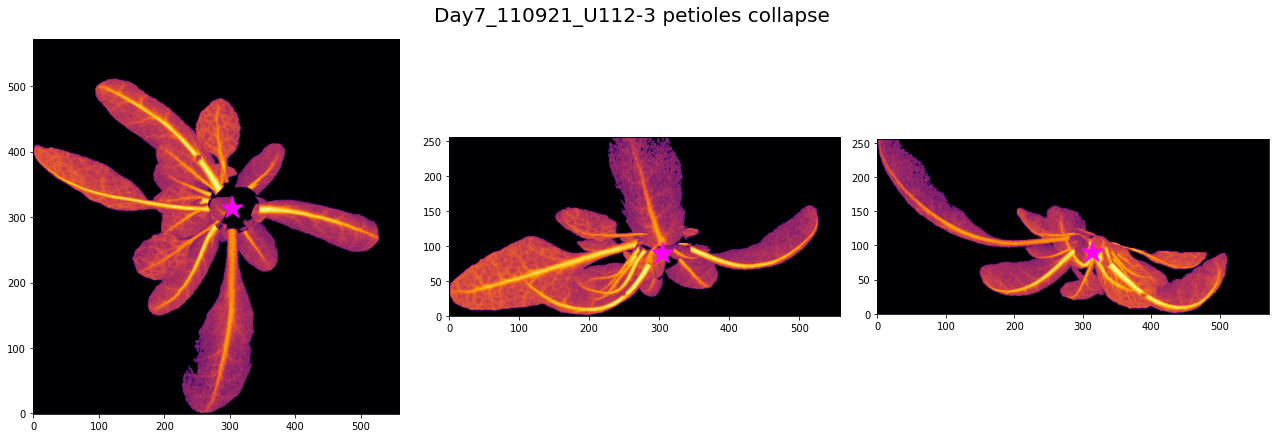

In [19]:
fig, ax = thales.plot_collapse_dimensions(tsnaps, bname, 'petioles', display=display, writefig=False, dst=dst)
ax[0].scatter(pcenter[2], pcenter[1], s=500, c='magenta', marker='*')
ax[1].scatter(pcenter[2], pcenter[0], s=500, c='magenta', marker='*')
ax[2].scatter(pcenter[1], pcenter[0], s=500, c='magenta', marker='*');

In [98]:
labels,num = ndimage.label(plant_tips, structure=ndimage.generate_binary_structure(img.ndim, 1))
hist,bins = np.histogram(labels, bins=num, range=(1,num+1))
argsort_hist = np.argsort(hist)[::-1]
print(num, hist[argsort_hist][:20])

cutoff = 1e-3
sz_hist = np.sum(hist)
struc=ndimage.generate_binary_structure(img.ndim, 2)
Comps = []

for j in range(num):
    i = argsort_hist[j]
    if(hist[i]/sz_hist > cutoff):
        mask = labels==i+1
        box = plant_tips.copy()
        box[~mask] = 0
        #box += plant_core
        
        snaps = thales.collapse_dimensions_max(box)
        Comps.append(snaps)
        
        print(j, np.around(100*hist[i]/sz_hist, 3), sep='\t')
        
print('Large components: ', len(Comps))

11 [296415 187436  56601  17032   2826   1471    904    358    170      1
      1]
0	52.629
1	33.28
2	10.05
3	3.024
4	0.502
5	0.261
6	0.161
Large components:  7


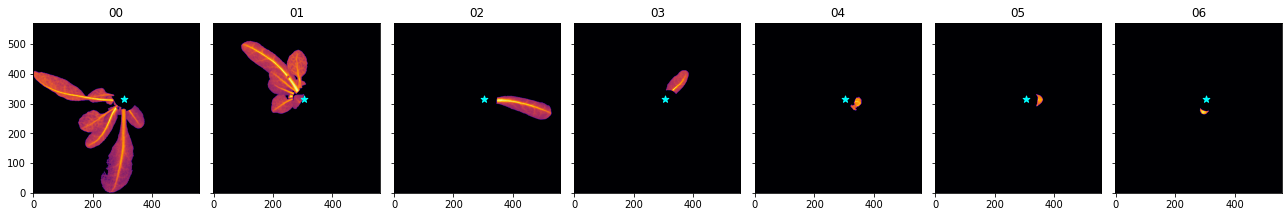

In [99]:
fig, ax = plt.subplots(1,7, figsize=(18,10), sharex=True, sharey=True)

for i,a in enumerate(ax.ravel()):
    a.imshow(Comps[i][0], origin='lower', cmap='inferno')#, vmax=1)
    a.set_title('{:02d}'.format(i))
    a.scatter(pcenter[2], pcenter[1], s=50, c='cyan', marker='*');

fig.tight_layout();

## IFT (Run 1)

In [22]:
markers = np.copy(box0).astype(int)
markers[markers == 0] = -1
markers[markers > 0] = 0

idx = 1
for mark in argsort_hist[list(range(len(Comps)))]+1:# + [10,11,13,16,18]] + 1:
    markers[labels == mark] = idx
    idx += 1
    
ift = ndimage.watershed_ift(box0, markers)

In [23]:
Leaves = [None for x in range(1,15)]
for idx in range(1,len(Comps)+1):
    mask = ift == idx
    box = img.copy()
    box[~mask] = 0
    
    filename = dst + bname + '_{}_leaf{:02d}.tif'.format(pidx, leafcounter) 
    tf.imwrite(filename, box, photometric='minisblack',compress=3)
    leafcounter += 1
    
    tsnap = thales.collapse_dimensions_max(box)
    Leaves[idx-1] = tsnap[0]

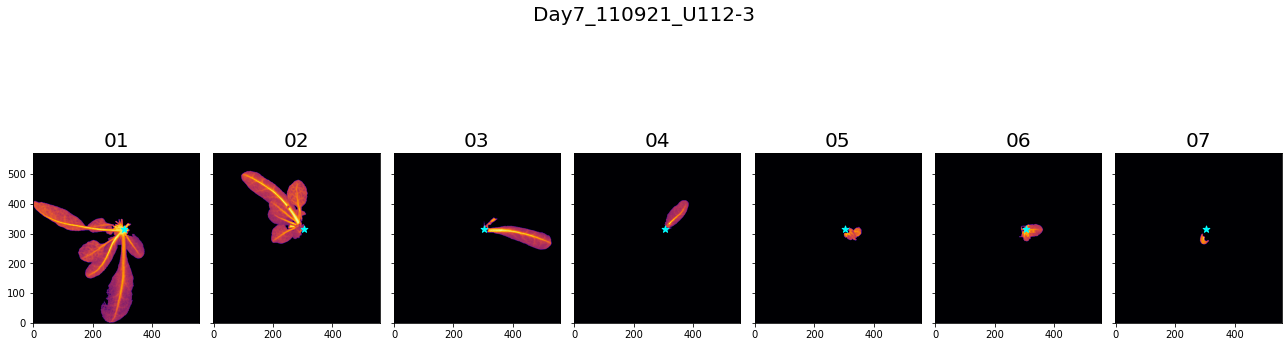

In [24]:
fig, ax = plt.subplots(1,7, figsize=(18,10), sharex=True, sharey=True)

for i,a in enumerate(ax.ravel()):
    a.imshow(Leaves[i], origin='lower', cmap='inferno')
    a.set_title('{:02d}'.format(i+1), fontsize=20)
    a.scatter(pcenter[2], pcenter[1], s=50, c='cyan', marker='*');

fig.suptitle(bname, fontsize=20, y=0.8)
fig.tight_layout();

filename = dst + bname + '_ift_segmentation.jpg'
#plt.savefig(filename, format='jpg', dpi=96, bbox_inches='tight', pil_kwargs={'optimize':True})

## IFT Run 2

In [96]:
iftidx = 7
mask = ift == iftidx
#box1 = box0.copy()
box1 = plant_tips.copy()
box1[~mask] = 0

100 % reduction from input


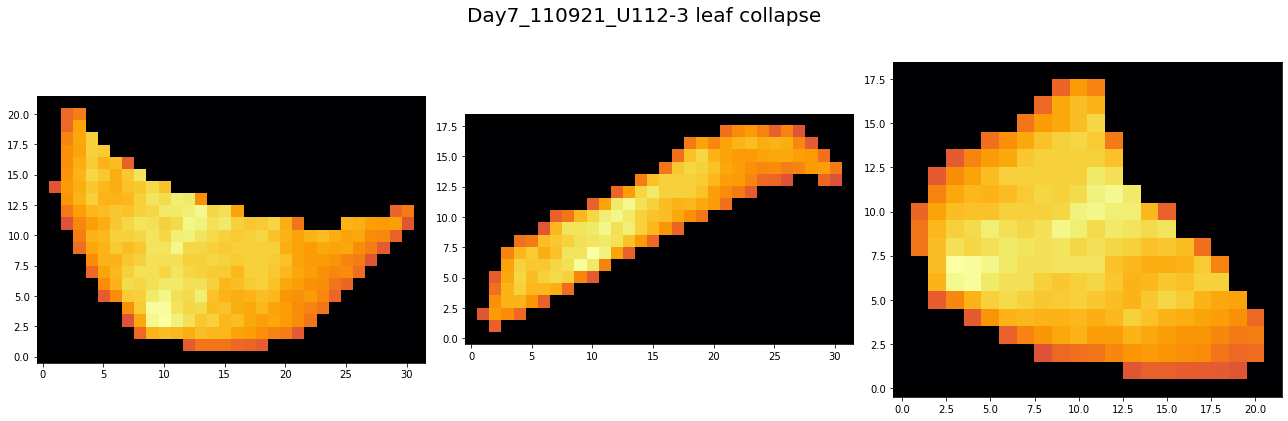

In [97]:
foo = box1.copy()
foo, _, _ = thales.clean_zeroes(foo)

tsnap = thales.collapse_dimensions_max(foo)
thales.plot_collapse_dimensions(tsnap, bname, 'leaf', display=display, writefig=False, dst=dst);

In [61]:
bar = box1.copy()
bar[bar < 80] = 0
#bar = ndimage.grey_closing(bar, size=(9,9,9))

labels,num = ndimage.label(bar, structure=ndimage.generate_binary_structure(img.ndim, 1))
hist,bins = np.histogram(labels, bins=num, range=(1,num+1))
argsort_hist = np.argsort(hist)[::-1]
print(num, hist[argsort_hist][:20])
sz_hist = np.sum(hist)

212 [78427 19395 12282    42    23    18    15    15    14    12    11    11
    10     9     8     8     7     7     6     6]


In [62]:
Comps = []
for j in range(num):
    i = argsort_hist[j]
    if(hist[i]/sz_hist > 1e-2):
        mask = labels==i+1
        box = box1.copy()
        box[~mask] = 0
        snaps = thales.collapse_dimensions_max(box)
        Comps.append(snaps)
        print(j, np.around(100*hist[i]/sz_hist, 3), sep='\t')
        
print('Large components: ', len(Comps))

0	70.891
1	17.531
2	11.102
Large components:  3


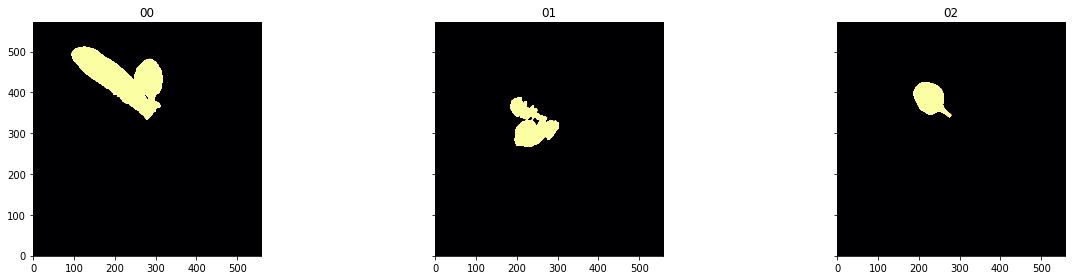

In [64]:
fig, ax = plt.subplots(1,3, figsize=(18,4), sharex=True, sharey=True)

for i,a in enumerate(ax.ravel()):
    a.imshow(Comps[i][0], origin='lower', cmap='inferno', vmax=1)
    a.set_title('{:02d}'.format(i))

fig.tight_layout();

In [65]:
mask = ift == iftidx
box2 = box0.copy()
box2[~mask] = 0

markers = np.copy(box2).astype(int)
markers[markers == 0] = -1
markers[markers > 0] = 0

idx = 1
for mark in argsort_hist[list(range(len(Comps)))]+1:# + [10,11,13,16,18]] + 1:
    markers[labels == mark] = idx
    idx += 1
    
ift1 = ndimage.watershed_ift(box2, markers)

In [66]:
Leaves = [None for x in range(1,15)]
for idx in range(1,len(Comps)+1):
    mask = ift1 == idx
    box = img.copy()
    box[~mask] = 0
    
    tsnap = thales.collapse_dimensions_max(box)
    Leaves[idx-1] = tsnap[0]

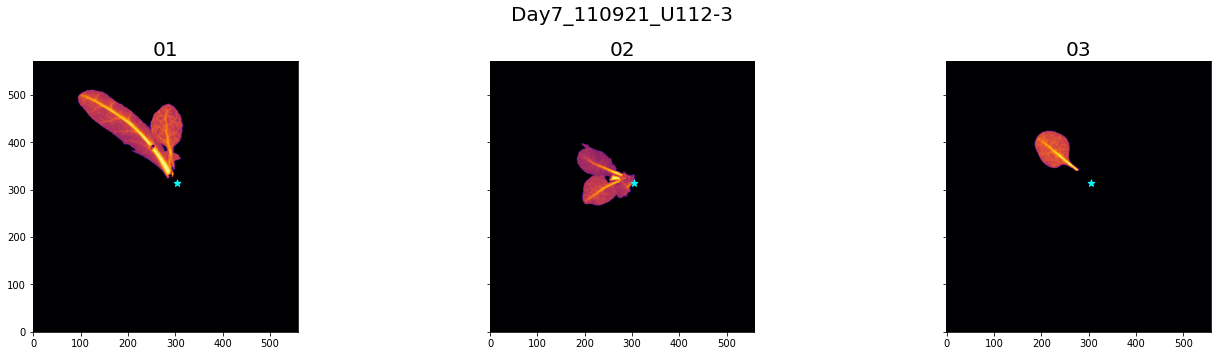

In [68]:
fig, ax = plt.subplots(1,3, figsize=(20,5), sharex=True, sharey=True)

for i,a in enumerate(ax.ravel()):
    a.imshow(Leaves[i], origin='lower', cmap='inferno')
    a.set_title('{:02d}'.format(i+1), fontsize=20)
    a.scatter(pcenter[2], pcenter[1], s=50, c='cyan', marker='*');

fig.suptitle(bname, fontsize=20)
fig.tight_layout();

filename = dst + bname + '_ift_segmentation.jpg'
plt.savefig(filename, format='jpg', dpi=96, bbox_inches='tight', pil_kwargs={'optimize':True})

In [69]:
Leaves = [None for x in range(1,15)]
for idx in range(1,len(Comps)+1):
    mask = ift1 == idx
    box = img.copy()
    box[~mask] = 0
    
    filename = dst + bname + '_{}_leaf{:02d}.tif'.format(pidx, leafcounter) 
    tf.imwrite(filename, box, photometric='minisblack',compress=3)
    leafcounter += 1
    
    tsnap = thales.collapse_dimensions_max(box)
    Leaves[idx-1] = tsnap[0]

## IFT (run 3)

98 % reduction from input


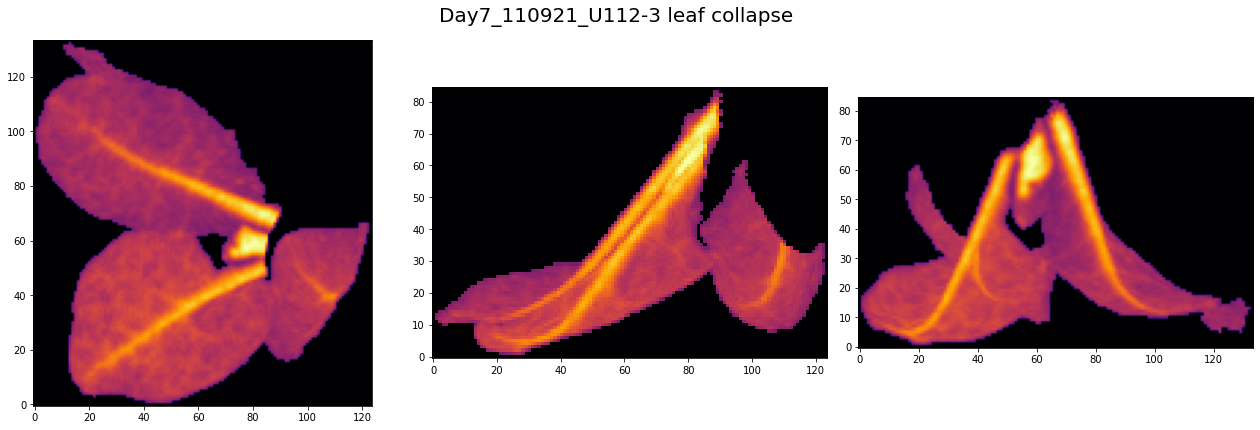

In [84]:
iftidx = 2
mask = ift1 == iftidx
#box1 = box0.copy()
box1 = plant_tips.copy()
box1[~mask] = 0

foo = box1.copy()
foo, _, _ = thales.clean_zeroes(foo)

tsnap = thales.collapse_dimensions_max(foo)
thales.plot_collapse_dimensions(tsnap, bname, 'leaf', display=display, writefig=False, dst=dst);

In [85]:
bar = box1.copy()
bar[bar < 90] = 0
#bar = ndimage.grey_closing(bar, size=(9,9,9))

labels,num = ndimage.label(bar, structure=ndimage.generate_binary_structure(img.ndim, 1))
hist,bins = np.histogram(labels, bins=num, range=(1,num+1))
argsort_hist = np.argsort(hist)[::-1]
print(num, hist[argsort_hist][:20])
sz_hist = np.sum(hist)

Comps = []
for j in range(num):
    i = argsort_hist[j]
    if(hist[i]/sz_hist > 1e-2):
        mask = labels==i+1
        box = box1.copy()
        box[~mask] = 0
        snaps = thales.collapse_dimensions_max(box)
        Comps.append(snaps)
        print(j, np.around(100*hist[i]/sz_hist, 3), sep='\t')
        
print('Large components: ', len(Comps))

167 [7603 2802  788   77   19   19   15   13   13   12   12   10    8    7
    7    7    7    6    6    5]
0	65.066
1	23.979
2	6.744
Large components:  3


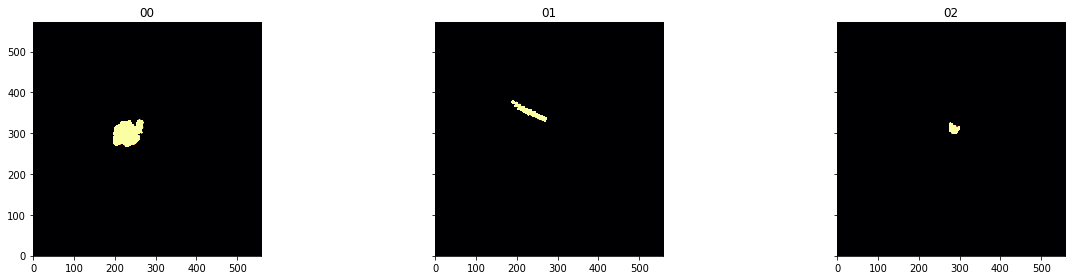

In [86]:
fig, ax = plt.subplots(1,3, figsize=(18,4), sharex=True, sharey=True)

for i,a in enumerate(ax.ravel()):
    a.imshow(Comps[i][0], origin='lower', cmap='inferno', vmax=1)
    a.set_title('{:02d}'.format(i))

fig.tight_layout();

In [87]:
mask = ift1 == iftidx
box2 = box0.copy()
box2[~mask] = 0

markers = np.copy(box2).astype(int)
markers[markers == 0] = -1
markers[markers > 0] = 0

idx = 1
for mark in argsort_hist[list(range(len(Comps)))]+1:# + [10,11,13,16,18]] + 1:
    markers[labels == mark] = idx
    idx += 1
    
ift2 = ndimage.watershed_ift(box2, markers)

In [88]:
Leaves = [None for x in range(1,15)]
for idx in range(1,len(Comps)+1):
    mask = ift2 == idx
    box = img.copy()
    box[~mask] = 0
    
    tsnap = thales.collapse_dimensions_max(box)
    Leaves[idx-1] = tsnap[0]

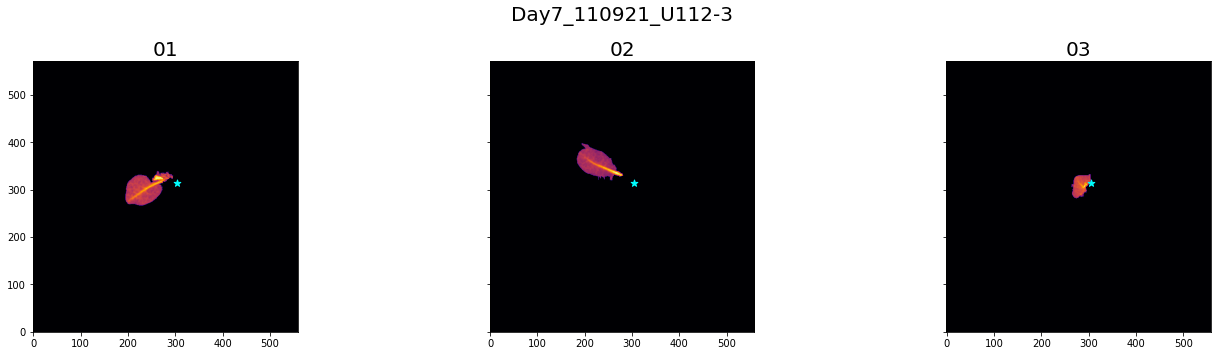

In [90]:
fig, ax = plt.subplots(1,3, figsize=(20,5), sharex=True, sharey=True)

for i,a in enumerate(ax.ravel()):
    a.imshow(Leaves[i], origin='lower', cmap='inferno')
    a.set_title('{:02d}'.format(i+1), fontsize=20)
    a.scatter(pcenter[2], pcenter[1], s=50, c='cyan', marker='*');

fig.suptitle(bname, fontsize=20)
fig.tight_layout();

In [91]:
Leaves = [None for x in range(1,15)]
for idx in range(1,len(Comps)+1):
    mask = ift2 == idx
    box = img.copy()
    box[~mask] = 0
    
    filename = dst + bname + '_{}_leaf{:02d}.tif'.format(pidx, leafcounter) 
    tf.imwrite(filename, box, photometric='minisblack',compress=3)
    leafcounter += 1
    
    tsnap = thales.collapse_dimensions_max(box)
    Leaves[idx-1] = tsnap[0]